In [1]:
import numpy as np
from numpy.linalg import inv
from numpy import dot
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append("utils")
import dynamic_backtesting as db

Trying to understand the behavior in 
$   v_t=\frac{v_{t-1}+(\gamma_D\Omega_{t+1|t})^{-1}A_{vv}\big[v_{t-1}-\frac{\text{aim}_t}{\textbf{1}' \text{aim}_t}\big]}{\textbf{1}'(v_{t-1}+(\gamma_D\Omega_{t+1|t})^{-1}A_{vv}\big[v_{t-1}-\frac{\text{aim}_t}{\textbf{1}' \text{aim}_t}\big])}$
when increasing $\gamma_D$

In [3]:
# Set up range of gammas, 0.05 seems to be about the numerical upper limit for stability
gamma_Ds = np.geomspace(1e-9, 0.05, 100)

# Random Omega from sample
Omega = np.array([[ 2.73805963,  1.7544843 ,  2.05477311,  1.87627376, -0.53622494],
                   [ 1.7544843 ,  1.48499002,  1.57017648,  1.49664961, -0.47394559],
                   [ 2.05477311,  1.57017648,  2.09115354,  1.63479301, -0.53458097],
                   [ 1.87627376,  1.49664961,  1.63479301,  1.79933064, -0.47319924],
                   [-0.53622494, -0.47394559, -0.53458097, -0.47319924,  0.74316583]])

First, $A_{vv}$

In [4]:
Avvs = [db.numerical_solver_multi(Omega, gamma_D)[0] for gamma_D in gamma_Ds]

In [5]:
Avvs_sum = pd.DataFrame([[gamma_D, np.sum(Avv)] for gamma_D, Avv in zip(gamma_Ds, Avvs)], columns=["gamma_D", "Avv"])
Avvs_sum.set_index("gamma_D", inplace=True, drop=True)

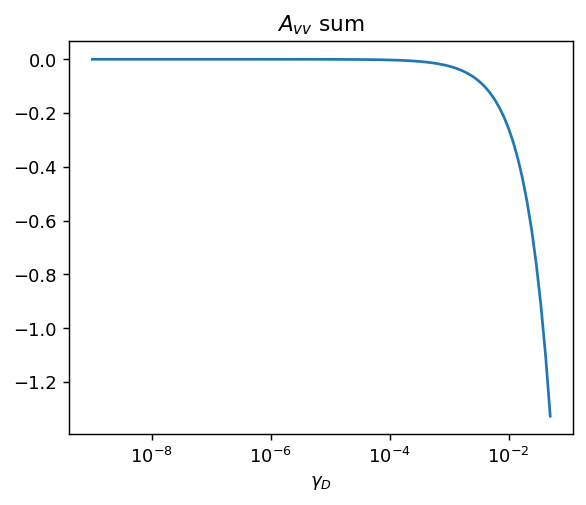

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=130)
ax.plot(Avvs_sum)
ax.set_title("$A_{vv}$ sum")
ax.set_xlabel("$\gamma_D$")
ax.set_xscale('log')

Lets try plotting all the elements by flattening:

In [25]:
Avvs_flat = pd.DataFrame([[gamma_D, *Avv.flatten()] for gamma_D, Avv in zip(gamma_Ds, Avvs)])
Avvs_flat.set_index(0, inplace=True, drop=True)

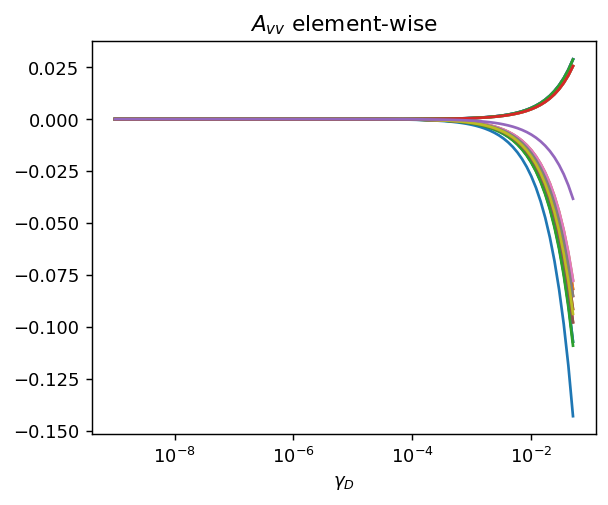

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=130)
ax.set_title("$A_{vv}$ element-wise")
ax.plot(Avvs_flat)
ax.set_xlabel("$\gamma_D$")
ax.set_xscale('log')

Second, $(\gamma_D\Omega_{t+1|t})^{-1}$

In [27]:
inverted_terms = [inv(gamma_D*Omega) for gamma_D in gamma_Ds]

In [28]:
inverted_terms_flat = pd.DataFrame([[gamma_D, *inverted_term.flatten()] for gamma_D, inverted_term in zip(gamma_Ds, inverted_terms)])
inverted_terms_flat.set_index(0, inplace=True, drop=True)

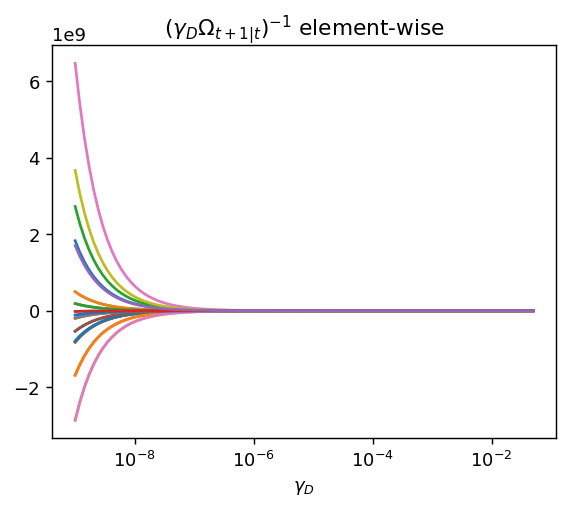

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=130)
ax.set_title("$(\gamma_D\Omega_{t+1|t})^{-1}$ element-wise")
ax.plot(inverted_terms_flat)
ax.set_xlabel("$\gamma_D$")
ax.set_xscale('log')

#### Seems like $A_{vv}$ and the modifier roughly cancel each other out

Putting it together in the "modifier" $(\gamma_D\Omega_{t+1|t})^{-1}A_{vv}$

In [37]:
modifiers = [dot(inverted_term, Avv) for inverted_term, Avv in zip(inverted_terms, Avvs)]

modifiers_flat = pd.DataFrame([[gamma_D, *modifier.flatten()] for gamma_D, modifier in zip(gamma_Ds, modifiers)])
modifiers_sum = pd.DataFrame([[gamma_D, np.sum(modifier)] for gamma_D, modifier in zip(gamma_Ds, modifiers)])

modifiers_flat.set_index(0, drop=True, inplace=True)
modifiers_sum.set_index(0, drop=True, inplace=True)

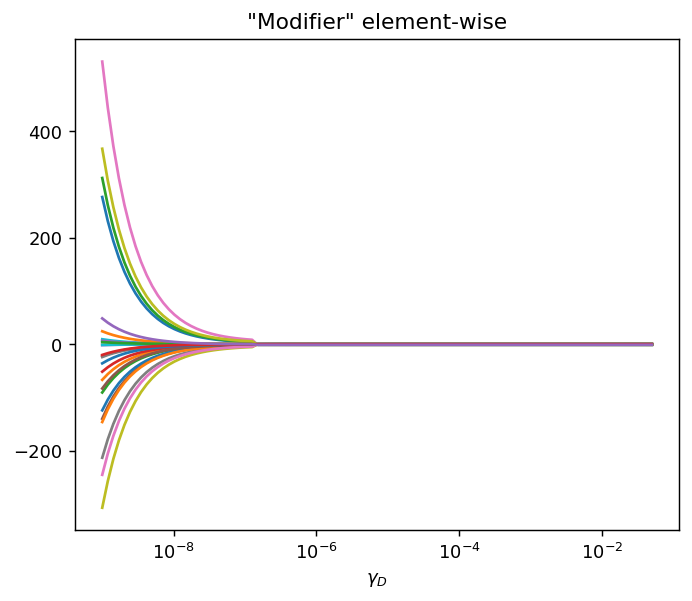

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=130)
ax.plot(modifiers_flat)
ax.set_title('"Modifier" element-wise')
ax.set_xlabel("$\gamma_D$")
ax.set_xscale('log')

Enhance...

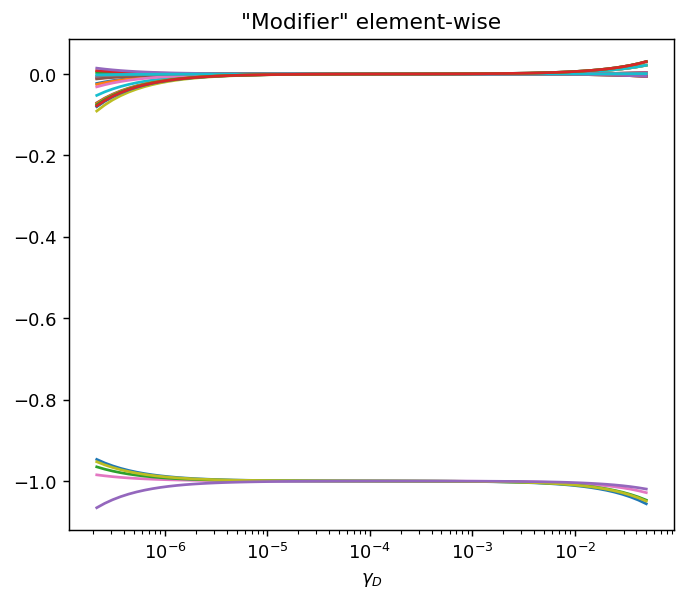

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=130)
ax.plot(modifiers_flat.loc[2e-7:])
ax.set_title('"Modifier" element-wise')
ax.set_xlabel("$\gamma_D$")
ax.set_xscale('log')

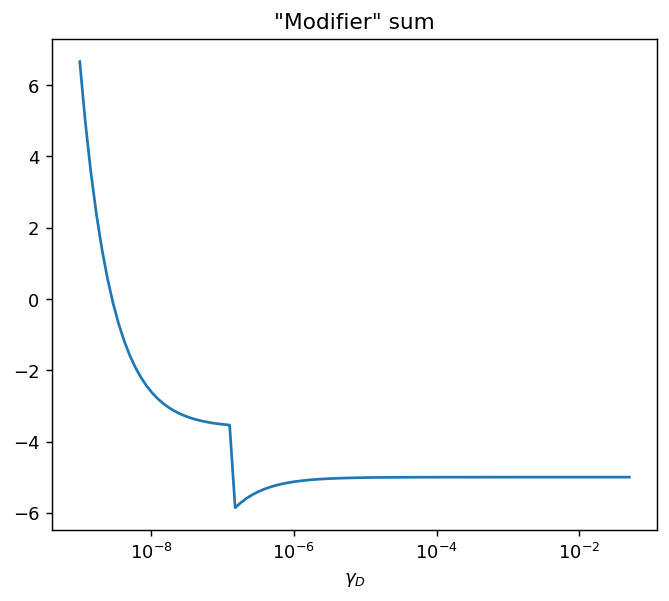

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=130)
ax.plot(modifiers_sum)
ax.set_title('"Modifier" sum')
ax.set_xlabel("$\gamma_D$")
ax.set_xscale('log')